In [24]:
#Importing libraries for data processing, modelling and visualizations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jyots\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
data = pd.read_csv('email.csv')
data.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [26]:
data.shape

(5171, 4)

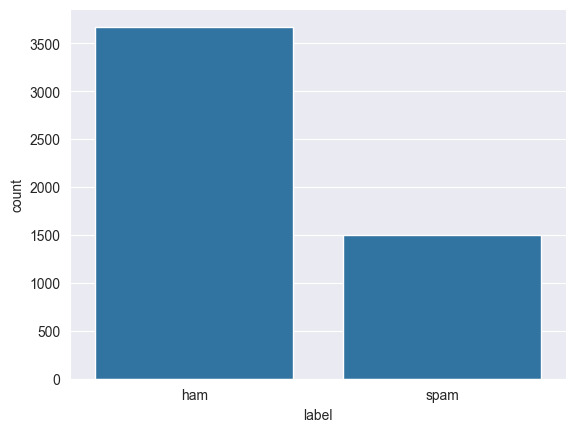

In [27]:
# visualize the label distribution to get understanding of the class distribution
sns.countplot(x='label', data=data)
plt.show()

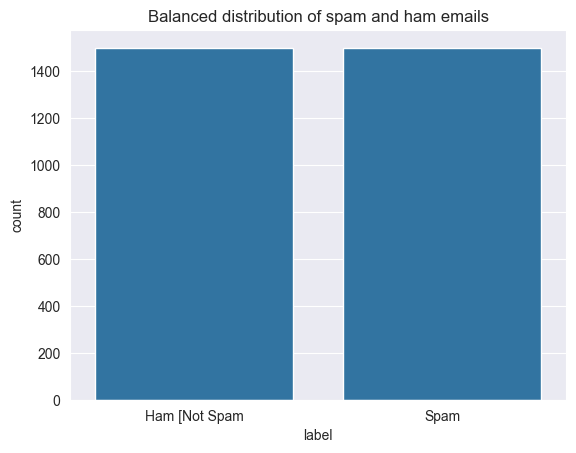

In [28]:
#To address the huge imbalance, we will downsample to match the majority class to minority class\
ham_msg = data[data['label'] == 'ham']
spam_msg = data[data['label'] == 'spam']

#downsample ham emails to match the number of spam emails
ham_msg_balanced = ham_msg.sample(n=len(spam_msg), random_state=42)

#combine balanced data
balanced_data = pd.concat([ham_msg_balanced, spam_msg]).reset_index(drop=True)

#Visualize the balanced dataset

sns.countplot(x='label', data=balanced_data)
plt.title("Balanced distribution of spam and ham emails")
plt.xticks(ticks=[0,1], labels=['Ham [Not Spam', 'Spam' ])
plt.show()


Cleaning the text
Textual data often requires preprocessing before feeding it into a machine learning model. Common steps include removing stopwords, punctuations, and performing stemming/lemmatization.

We’ll perform the following steps:

Stopwords Removal
Punctuations Removal
Stemming or Lemmatization



In [29]:
balanced_data['text'] = balanced_data['text'].str.replace('Subject', '')
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,3444,ham,: conoco - big cowboy\r\ndarren :\r\ni ' m not...,0
1,2982,ham,: feb 01 prod : sale to teco gas processing\r\...,0
2,2711,ham,": california energy crisis\r\ncalifornia  , s...",0
3,3116,ham,: re : nom / actual volume for april 23 rd\r\n...,0
4,1314,ham,: eastrans nomination changes effective 8 / 2 ...,0


In [30]:
punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)

balanced_data['text'] = balanced_data['text'].apply(lambda x: remove_punctuations(x))
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,3444,ham,conoco big cowboy\r\ndarren \r\ni m not sur...,0
1,2982,ham,feb 01 prod sale to teco gas processing\r\ns...,0
2,2711,ham,california energy crisis\r\ncalifornia  s p...,0
3,3116,ham,re nom actual volume for april 23 rd\r\nwe ...,0
4,1314,ham,eastrans nomination changes effective 8 2 0...,0


Below function helps to remove stopper function

In [31]:
def remove_stopwords(text):
    stop_words = stopwords.words('english')

    imp_words = []

    #storing the important words

    for word in str(text).split():
        word = word.lower()

        if word not in stop_words:
            imp_words.append(word)
    output = " ".join(imp_words)

    return output

balanced_data['text'] = balanced_data['text'].apply(lambda text : remove_stopwords(text))
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,3444,ham,conoco big cowboy darren sure help know else a...,0
1,2982,ham,feb 01 prod sale teco gas processing sale deal...,0
2,2711,ham,california energy crisis california  power cr...,0
3,3116,ham,nom actual volume april 23 rd agree eileen pon...,0
4,1314,ham,eastrans nomination changes effective 8 2 00 p...,0


Visualization Word Cloud

A word cloud is a text visualization tool that help's us to get insights into the most frequent words present in the corpus of the data.

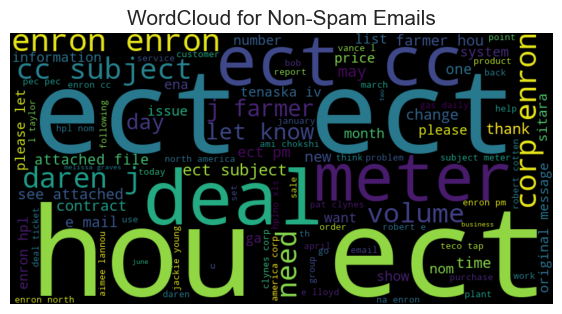

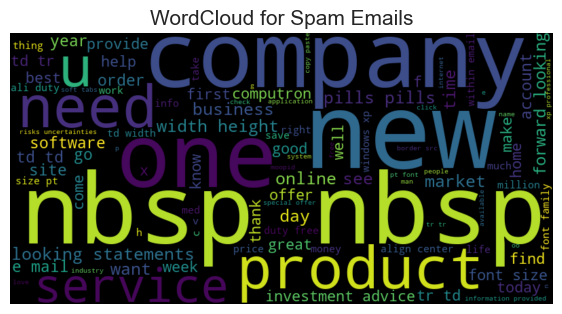

In [32]:
def plot_word_cloud(data, typ):
    email_corpus = " ".join(data['text'])
    wc = WordCloud(background_color='black', max_words=100, width=800, height=400).generate(email_corpus)
    plt.figure(figsize=(7, 7))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'WordCloud for {typ} Emails', fontsize=15)
    plt.axis('off')
    plt.show()

plot_word_cloud(balanced_data[balanced_data['label'] == 'ham'], typ='Non-Spam')
plot_word_cloud(balanced_data[balanced_data['label'] == 'spam'], typ='Spam')



Tokenization and Padding
- Tokenization: Converts each word into a unique integer.
- Padding: Ensures that all text sequences have the same length, making them compatible with the model.

In [33]:
train_X, test_X, train_Y, test_Y = train_test_split(
    balanced_data['text'], balanced_data['label'], test_size=0.2, random_state=42
)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)

train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)

max_len = 100  # Maximum sequence length
train_sequences = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
test_sequences = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

train_Y = (train_Y == 'spam').astype(int)
test_Y = (test_Y == 'spam').astype(int)

Define the model

We will build a deep learning model using a Sequential architecture. This model will include:

- Embedding Layer: Learns vector representations of words.
- LSTM Layer: Captures patterns in sequences.
- Fully Connected Layer: Extracts relevant features.
- Output Layer: Predicts whether an email is spam or not.

In [34]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=32, input_length=max_len),
    tf.keras.layers.LSTM(16),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer
])

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Train the Model

We train the model using EarlyStopping and ReduceLROnPlateau callbacks. These callbacks help stop the training early if the model’s performance doesn’t improve and reduce the learning rate to fine-tune the model.

In [35]:
es = EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True)
lr = ReduceLROnPlateau(patience=2, monitor='val_loss', factor=0.5, verbose=0)

history = model.fit(
    train_sequences, train_Y,
    validation_data=(test_sequences, test_Y),
    epochs=20,
    batch_size=32,
    callbacks=[lr, es]
)

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.5788 - loss: 0.6797 - val_accuracy: 0.8317 - val_loss: 0.4840 - learning_rate: 0.0010
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9337 - loss: 0.2459 - val_accuracy: 0.9567 - val_loss: 0.1611 - learning_rate: 0.0010
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9621 - loss: 0.1524 - val_accuracy: 0.9667 - val_loss: 0.1468 - learning_rate: 0.0010
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9587 - loss: 0.1664 - val_accuracy: 0.9483 - val_loss: 0.2000 - learning_rate: 0.0010
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.9633 - loss: 0.1472 - val_accuracy: 0.9533 - val_loss: 0.1782 - learning_rate: 0.0010
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.9662 - loss: 0.1351 - val_accuracy: 0.9550 - val_loss: 0.1754 - learning_rate: 5.0000e-04


In [36]:
# ✅ Save model and tokenizer after training
model.save("spam_model.keras")

import pickle
with open("tokenizer.pkl", "wb") as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

After training, we evaluate the model on the test data to measure its performance.

In [37]:
test_loss, test_accuracy = model.evaluate(test_sequences, test_Y)
print('Test Loss :',test_loss)
print('Test Accuracy :',test_accuracy)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9667 - loss: 0.1468
Test Loss : 0.14684568345546722
Test Accuracy : 0.9666666388511658


Thus, the training accuracy turns out to be 97% which is quite satisfactory.

Having trained our model, we can plot a graph depicting the variance of training and validation accuracies with the no. of epochs.

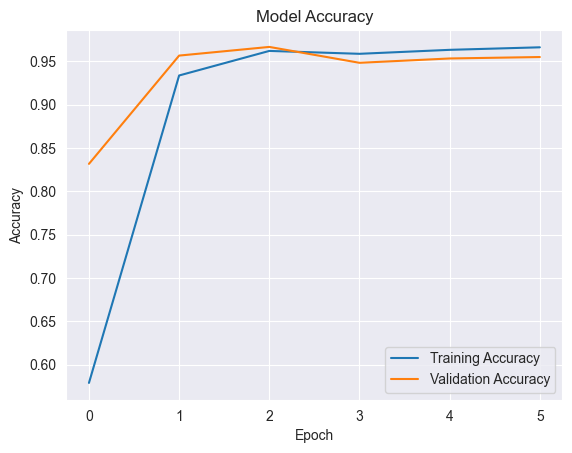

In [38]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

By following these steps, we have successfully built a machine learning model that can classify emails as spam or ham. With further optimization, this model can be fine-tuned to improve its performance even more.

